In [ ]:
!pip install swig
!pip install gymnasium[box2d]

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils as torch_utils
from torch.utils.data import Dataset, DataLoader
import numpy as np

env = gym.make("LunarLander-v2")

seed = 719


In [ ]:
seed

719

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
generator = torch.Generator().manual_seed(seed)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


state, info = env.reset()
input_size = len(state)
hidden_size = 64
output_size = env.action_space.n
learning_rate = 0.001
# clip_value = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleClassifier(input_size, hidden_size, output_size).to(device)
crite = nn.CrossEntropyLoss()
opti = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)


SimpleClassifier(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


#
#


class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#
#



In [ ]:
BATCH_SIZE = 64
GAMMA = 0.99
# EPS_START = 0.9
# EPS_END = 0.05
# EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [ ]:
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(50000)


eps_policy = 1
# eps_nn = 1


def select_action(state, nn_action):
    global eps_policy, eps_nn
    sample = random.random()
    steps_done =0
    # if(nn_action):
    #     eps_threshold = eps_policy
    # else:
    #     eps_threshold = eps_policy
    eps_threshold = eps_policy

    if sample > eps_threshold:
        with torch.no_grad():
            if (not nn_action):
              return policy_net(state).max(1).indices.view(1, 1)
            else:
                neural_list = model(state)
                neural_probs = torch.softmax(neural_list, dim=1)
                categorical_dist = torch.distributions.categorical.Categorical(neural_probs)
                action = categorical_dist.sample()
                return torch.tensor([[action.item()]], device=device, dtype=torch.long)
    else:
        return torch.tensor([[np.random.randint(0,4)]], device=device, dtype=torch.long)

In [ ]:
neural_epi = 0
neural_data = []
final_neural_data = []
episode_durations = []
episode_durations2 = []
# trained_count = 0


Training_period = False
data_append_period = False
after_uncertainity = False
First_trained = -1
First_used = -1
converge_step = -1


def plot_durations(show_result=False):
    global Training_period, data_append_period, after_uncertainity, First_trained, First_used, converge_step

    plt.figure(1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    durations2_t = torch.tensor(episode_durations2, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')

    plt.plot(durations_t.numpy(), color='Green', label='Policy Net')

    if(First_trained!=-1):
        end_index = min(First_trained + len(durations2_t), len(durations_t))
        plt.plot(range(First_trained, end_index), durations2_t[:end_index - First_trained].numpy(), color='blue', label='Neural Network')

    plt.legend()

    #Training
    if ((Training_period) and durations2_t[-1:]>=200):
        Training_period = False
        data_append_period = True
        if(First_used == -1):
            First_used = len(durations_t)

    #data-append
    if((data_append_period)  and ((len(durations2_t))-(First_used-First_trained)>=60)):
        data_append_period = False
        after_uncertainity = True

    #converge
    if (len(durations_t) >= 10) and (all(reward > 200 for reward in durations_t[-10:])):
        converge_step = len(durations_t)

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
# up/down/left/right

In [ ]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 500

# seed_array = [random.randint(1, 1000) for _ in range(num_episodes)]    #same initial state seeds for all episodes.

In [ ]:
# policy_ind = []
# nn_ind = []

In [ ]:
def train_all():
    # global trained_count
    # trained_count += 1
    final_neural_data.extend(neural_data)
    data_loader1 = torch.utils.data.DataLoader(neural_data, batch_size= 8, shuffle=True)
    data_loader2 = torch.utils.data.DataLoader(final_neural_data[-1000:], batch_size= 32, shuffle=True)

    for epoch in range(50):
        for inputs, labels in data_loader1:
            inputs = inputs.to(device)
            labels = labels.to(device)
            if inputs.size(0) == 1:
                inputs = inputs.squeeze(0)
            outputs = model(inputs)
            if outputs.dim() > 2:
              outputs = outputs.squeeze()
            loss = crite(outputs, labels)
            opti.zero_grad()
            loss.backward()
            opti.step()
    for epoch in range(200):
        for inputs, labels in data_loader2:
            inputs = inputs.to(device)
            labels = labels.to(device)
            if inputs.size(0) == 1:
                inputs = inputs.squeeze(0)
            outputs = model(inputs)
            if outputs.dim() > 2:
              outputs = outputs.squeeze()
            loss = crite(outputs, labels)
            opti.zero_grad()
            loss.backward()
            opti.step()





Complete


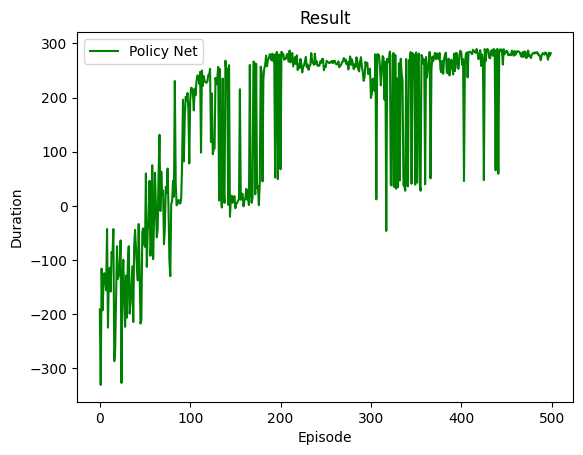

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
for i_episode in range(num_episodes):
    # if converge_step != -1:
    #   print("Converge at step",converge_step)
    #   break

    #policy-net
    policy_rew = 0
    neural_data.clear()
    state, info = env.reset(seed = seed)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(state,False)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        policy_rew += reward
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        if(not data_append_period):
            memory.push(state, action, next_state, reward)
        neural_data.append((state,action.item()))
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # if (done) and (policy_rew>=neural_epi) and (after_uncertainity == False):
        #     train_all()
        #     neural_epi = policy_rew
        #     if First_trained == -1 :
        #         First_trained = i_episode
        #     if (not Training_period) and (not data_append_period):
        #         Training_period = True
        #     # if trained_count >= 4 :

        if (done) :
            episode_durations.append(policy_rew)
            if eps_policy > 0.05 :
                  eps_policy -= (1/100)
            break



    # if(Training_period or data_append_period):
    #     neural_data.clear()
    #     nn_rew = 0
    #     state_n, info = env.reset(seed = seed)
    #     state_n = torch.tensor(state_n, dtype=torch.float32, device=device).unsqueeze(0)
    #     for t in count():
    #       action = select_action(state_n,True)
    #       observation, reward, terminated, truncated, _ = env.step(action.item())
    #       reward = torch.tensor([reward], device=device)
    #       nn_rew += reward
    #       done = terminated or truncated
    #       if terminated:
    #           next_state = None
    #       else:
    #           next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    #       if data_append_period:
    #           memory.push(state_n, action, next_state, reward)
    #       neural_data.append((state_n,action.item()))
    #       state_n = next_state

    #       if (done) and (nn_rew >= neural_epi):
    #           train_all()
    #           neural_epi = nn_rew

    #       if (done):
    #           episode_durations2.append(nn_rew)
    #           # if eps_nn > 0.05 :
    #           #     eps_nn -= (1/50)
    #           break
    plot_durations()



print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
for i in range(12, len(episode_durations)):
    avg = sum(episode_durations[i-10:i]) / 10
    if avg >= 200:
        print(i)
        break


110


In [ ]:
file_path = str(seed)+"_PN.txt"
with open(file_path, "w") as file:
    for index, item in enumerate(episode_durations):
        file.write(f"{index},{item}\n")